# Facial Expression Recognition

Nguyễn Hữu Phong - BIT240181 - Leader

Triệu Hồng Quân - BIT240188

Trần Hoàng Hải - BIT240084

---

#### FILE 1: PART 1 - PART 3.1

In [19]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Other utilities
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


---
# PART 1: Dataset Preparation (2 marks)
---

## 1.1. Load the pre-split dataset from the provided training and testing folders (1 mark)

In [ ]:
# Define data paths
DATA_DIR = 'Data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Define emotion labels (RAF-DB uses 1-7 encoding)
EMOTION_LABELS = {
    1: 'Surprise',
    2: 'Fear', 
    3: 'Disgust',
    4: 'Happiness',
    5: 'Sadness',
    6: 'Anger',
    7: 'Neutral'
}

# Image parameters
IMG_SIZE = 224
NUM_CLASSES = 7

In [ ]:
def load_dataset(data_dir, img_size=224):
    images = []
    labels = []
    file_paths = []
    
    for label in range(1, 8):
        folder_path = os.path.join(data_dir, str(label))
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist")
            continue
        
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Loading {EMOTION_LABELS[label]} ({label}): {len(image_files)} images")
        
        for img_file in tqdm(image_files, desc=f"Loading {EMOTION_LABELS[label]}", leave=False):
            img_path = os.path.join(folder_path, img_file)
            
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                
                images.append(img_array)
                labels.append(label - 1)
                file_paths.append(img_path)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels), file_paths

In [ ]:
# Load training data
print("=" * 60)
print("Loading Training Dataset...")
print("=" * 60)
X_train, y_train, train_paths = load_dataset(TRAIN_DIR, IMG_SIZE)

Loading Training Dataset...
Loading Surprise (1): 1290 images


Loading Fear (2): 281 images


Loading Disgust (3): 717 images


Loading Happiness (4): 4772 images


Loading Sadness (5): 1982 images


Loading Anger (6): 705 images


Loading Neutral (7): 2524 images


In [ ]:
# Load testing data
print("\n" + "=" * 60)
print("Loading Testing Dataset...")
print("=" * 60)
X_test, y_test, test_paths = load_dataset(TEST_DIR, IMG_SIZE)


Loading Testing Dataset...
Loading Surprise (1): 329 images


Loading Fear (2): 74 images


Loading Disgust (3): 160 images


Loading Happiness (4): 1185 images


Loading Sadness (5): 478 images


Loading Anger (6): 162 images


Loading Neutral (7): 680 images


In [ ]:
# Display loaded data information
print("\n" + "=" * 60)
print("Dataset Loading Complete!")
print("=" * 60)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"\nTesting set shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Dataset Loading Complete!

Training set shape: (12271, 224, 224, 3)
Training labels shape: (12271,)

Testing set shape: (3068, 224, 224, 3)
Testing labels shape: (3068,)


## 1.2. Report the total number of samples, features, and classes (1 mark)

In [ ]:
# Calculate dataset statistics
total_samples = len(X_train) + len(X_test)
train_samples = len(X_train)
test_samples = len(X_test)

# Features: Height x Width x Channels (for image data)
image_height, image_width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
num_features = image_height * image_width * channels

# Number of classes
num_classes = len(EMOTION_LABELS)

print("=" * 60)
print("DATASET STATISTICS REPORT")
print("=" * 60)
print(f"\nTotal number of samples in the dataset: {total_samples}")
print(f"   - Training samples: {train_samples}")
print(f"   - Testing samples: {test_samples}")
print(f"\nNumber of features: {num_features:,}")
print(f"   - Image dimensions: {image_height} x {image_width} x {channels}")
print(f"   - Height: {image_height} pixels")
print(f"   - Width: {image_width} pixels")
print(f"   - Channels: {channels} (RGB)")
print(f"\nNumber of classes: {num_classes}")
print("   Classes:")
for idx, (key, emotion) in enumerate(EMOTION_LABELS.items()):
    print(f"     {idx}: {emotion}")

DATASET STATISTICS REPORT

Total number of samples in the dataset: 15339
   - Training samples: 12271
   - Testing samples: 3068

Number of features: 150,528
   - Image dimensions: 224 x 224 x 3
   - Height: 224 pixels
   - Width: 224 pixels
   - Channels: 3 (RGB)

Number of classes: 7
   Classes:
     0: Surprise
     1: Fear
     2: Disgust
     3: Happiness
     4: Sadness
     5: Anger
     6: Neutral


In [ ]:
# Class distribution analysis
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)

# Training set distribution
train_unique, train_counts = np.unique(y_train, return_counts=True)
print("\nTraining Set Distribution:")
for label, count in zip(train_unique, train_counts):
    emotion = EMOTION_LABELS[label + 1]
    percentage = (count / len(y_train)) * 100
    print(f"   {emotion}: {count} samples ({percentage:.2f}%)")

# Testing set distribution
test_unique, test_counts = np.unique(y_test, return_counts=True)
print("\nTesting Set Distribution:")
for label, count in zip(test_unique, test_counts):
    emotion = EMOTION_LABELS[label + 1]
    percentage = (count / len(y_test)) * 100
    print(f"   {emotion}: {count} samples ({percentage:.2f}%)")


CLASS DISTRIBUTION

Training Set Distribution:
   Surprise: 1290 samples (10.51%)
   Fear: 281 samples (2.29%)
   Disgust: 717 samples (5.84%)
   Happiness: 4772 samples (38.89%)
   Sadness: 1982 samples (16.15%)
   Anger: 705 samples (5.75%)
   Neutral: 2524 samples (20.57%)

Testing Set Distribution:
   Surprise: 329 samples (10.72%)
   Fear: 74 samples (2.41%)
   Disgust: 160 samples (5.22%)
   Happiness: 1185 samples (38.62%)
   Sadness: 478 samples (15.58%)
   Anger: 162 samples (5.28%)
   Neutral: 680 samples (22.16%)


---
# PART 2: Machine Learning and Deep Learning Pipelines (2 marks)
---

## 2.1. Sự khác biệt chính giữa Machine Learning (ML) và Deep Learning (DL) Pipeline (1 mark)

### Machine Learning (ML) Pipeline:

1. **Feature Extraction (Thủ công)**:
   - Yêu cầu kiến thức chuyên môn để thiết kế và trích xuất các đặc trưng phù hợp
   - Các đặc trưng phổ biến cho FER: HOG (Histogram of Oriented Gradients), LBP (Local Binary Patterns), SIFT, facial landmarks
   - Các features được thiết kế thủ công và định nghĩa trước

2. **Data Preprocessing**:
   - Chuẩn hóa features (normalization/standardization)
   - Giảm chiều dữ liệu (PCA, LDA)
   - Lựa chọn features

3. **Model Complexity**:
   - Các mô hình đơn giản hơn (SVM, Random Forest, KNN)
   - Ít tham số cần điều chỉnh hơn
   - Thời gian huấn luyện nhanh hơn

4. **Data Requirements**:
   - Có thể hoạt động với tập dữ liệu nhỏ hơn
   - Ít bị overfitting trên dữ liệu nhỏ

5. **Interpretability**:
   - Dễ giải thích và hiểu hơn
   - Các features có ý nghĩa rõ ràng

### Deep Learning (DL) Pipeline:

1. **Feature Extraction (Tự động)**:
   - Các features được học tự động từ dữ liệu thô
   - Các lớp CNN học các đặc trưng phân cấp (edges → textures → patterns → objects)
   - Học end-to-end

2. **Data Preprocessing**:
   - Tiền xử lý tối thiểu (normalization, augmentation)
   - Đầu vào là giá trị pixel thô
   - Data augmentation để tăng kích thước tập dữ liệu hiệu quả

3. **Model Complexity**:
   - Kiến trúc phức tạp (CNN, ResNet, VGG)
   - Hàng triệu tham số
   - Yêu cầu nhiều tài nguyên tính toán hơn (GPU)

4. **Data Requirements**:
   - Yêu cầu lượng dữ liệu lớn
   - Có thể tận dụng transfer learning từ các mô hình pretrained

5. **Performance**:
   - Thường đạt accuracy cao hơn trên các tác vụ phức tạp
   - Có thể nắm bắt các patterns tinh tế và quan hệ phi tuyến

### Bảng so sánh:

| Khía cạnh | Machine Learning | Deep Learning |
|-----------|-----------------|---------------|
| Feature Extraction | Thủ công/Handcrafted | Tự động/Learned |
| Model Complexity | Đơn giản | Phức tạp |
| Data Requirement | Nhỏ-Trung bình | Lớn |
| Training Time | Nhanh | Chậm |
| Hardware | CPU đủ dùng | Khuyến nghị GPU |
| Interpretability | Cao | Thấp (Black-box) |
| Accuracy (Complex Tasks) | Trung bình | Cao |

## 2.2. Phương pháp trích xuất đặc trưng cho ML Pipeline: HOG (Histogram of Oriented Gradients) (1 mark)

### Mô tả:
HOG (Histogram of Oriented Gradients) là một kỹ thuật feature descriptor được sử dụng trong computer vision để phát hiện và nhận dạng đối tượng. Nó hoạt động bằng cách tính toán phân bố của hướng gradient trong các vùng cục bộ của ảnh.

### Tại sao HOG phù hợp cho FER:

1. **Edge Detection**: HOG nắm bắt sự thay đổi trong cường độ pixel (cạnh), rất quan trọng cho các biểu cảm khuôn mặt
2. **Local Structure**: Nó nắm bắt cấu trúc cục bộ của khuôn mặt (nếp nhăn, khóe miệng, hình dạng lông mày)
3. **Illumination Invariant**: Quy trình normalization làm cho nó bất biến với thay đổi ánh sáng
4. **Compact Representation**: Tạo ra vector đặc trưng có kích thước cố định bất kể kích thước ảnh đầu vào

### Cách HOG trích xuất đặc trưng:

1. **Gradient Computation**: Tính toán gradient theo hướng x và y cho mỗi pixel
2. **Cell Division**: Chia ảnh thành các ô nhỏ (cells) (ví dụ: 8×8 pixels)
3. **Histogram Creation**: Tạo histogram của hướng gradient cho mỗi cell
4. **Block Normalization**: Nhóm các cells thành blocks và normalize
5. **Feature Vector**: Ghép nối tất cả histogram thành một vector đặc trưng cuối cùng

### Các tham số được sử dụng:
- **orientations**: Số bins trong histogram hướng (9 bins = khoảng 20° mỗi bin)
- **pixels_per_cell**: Kích thước của mỗi cell (8×8 pixels)
- **cells_per_block**: Số cells trong mỗi block để normalization (2×2 cells)

Các parameters này cung cấp sự cân bằng tốt giữa việc nắm bắt đủ chi tiết và giữ kích thước feature vector có thể quản lý được cho bài toán FER.

In [ ]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(images, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9):
    features = []
    
    for img in tqdm(images, desc="Extracting HOG features"):
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
        
        gray = cv2.resize(gray, (128, 128))
        
        hog_features = hog(
            gray,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False,
            feature_vector=True
        )
        
        features.append(hog_features)
    
    return np.array(features)

In [ ]:
# Extract HOG features from training and testing data
print("Extracting HOG features from training data...")
X_train_hog = extract_hog_features(X_train)
print(f"Training HOG features shape: {X_train_hog.shape}")

print("\nExtracting HOG features from testing data...")
X_test_hog = extract_hog_features(X_test)
print(f"Testing HOG features shape: {X_test_hog.shape}")

print(f"\nNumber of HOG features per image: {X_train_hog.shape[1]}")

Extracting HOG features from training data...


Extracting HOG features: 100%|██████████| 12271/12271 [00:35<00:00, 341.70it/s]


Training HOG features shape: (12271, 1764)

Extracting HOG features from testing data...


Extracting HOG features: 100%|██████████| 3068/3068 [00:08<00:00, 357.76it/s]

Testing HOG features shape: (3068, 1764)

Number of HOG features per image: 1764


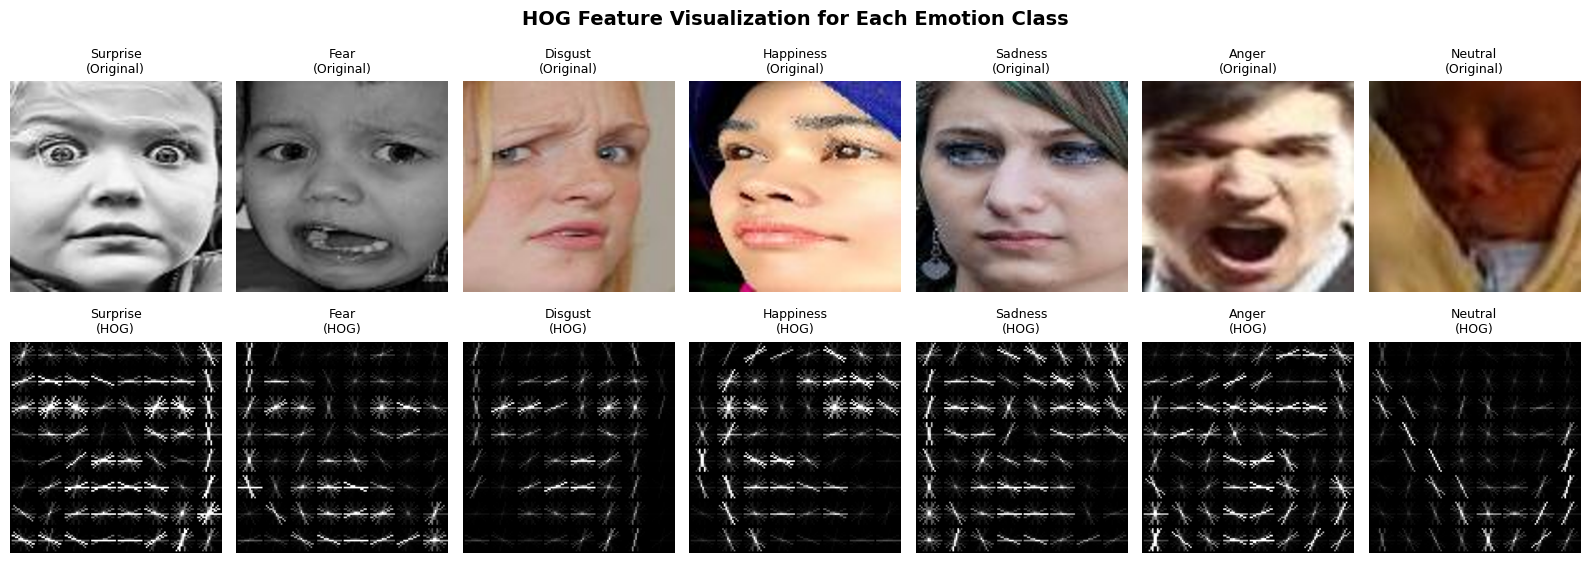

In [ ]:
# Visualize HOG features for sample images
fig, axes = plt.subplots(2, 7, figsize=(16, 6))
fig.suptitle('HOG Feature Visualization for Each Emotion Class', fontsize=14, fontweight='bold')

for idx, (label, emotion) in enumerate(EMOTION_LABELS.items()):
    class_indices = np.where(y_train == (label - 1))[0]
    
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        
        gray = cv2.cvtColor(X_train[sample_idx], cv2.COLOR_RGB2GRAY)
        gray = cv2.resize(gray, (128, 128))
        
        _, hog_image = hog(
            gray,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        axes[0, idx].imshow(X_train[sample_idx])
        axes[0, idx].set_title(f'{emotion}\n(Original)', fontsize=9)
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(hog_image_rescaled, cmap='gray')
        axes[1, idx].set_title(f'{emotion}\n(HOG)', fontsize=9)
        axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('hog_features.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Train a simple ML model (SVM) using HOG features to demonstrate the ML pipeline
print("=" * 60)
print("Training SVM Classifier with HOG Features (ML Pipeline Demo)")
print("=" * 60)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)

# Train SVM classifier
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
print("\nTraining SVM...")
svm_classifier.fit(X_train_scaled, y_train)

# Evaluate
y_pred_svm = svm_classifier.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Accuracy: {svm_accuracy:.4f}")

# Classification report
emotion_names = [EMOTION_LABELS[i+1] for i in range(7)]
print("\nClassification Report (SVM with HOG):")
print(classification_report(y_test, y_pred_svm, target_names=emotion_names))

Training SVM Classifier with HOG Features (ML Pipeline Demo)

Training SVM...

SVM Accuracy: 0.7480

Classification Report (SVM with HOG):
              precision    recall  f1-score   support

    Surprise       0.72      0.67      0.70       329
        Fear       0.82      0.36      0.50        74
     Disgust       0.49      0.28      0.35       160
   Happiness       0.84      0.91      0.88      1185
     Sadness       0.67      0.66      0.67       478
       Anger       0.66      0.57      0.61       162
     Neutral       0.69      0.76      0.72       680

    accuracy                           0.75      3068
   macro avg       0.70      0.60      0.63      3068
weighted avg       0.74      0.75      0.74      3068



---
# PART 3: Model Training and Evaluation (6 marks)
---

## 3.1. Huấn luyện kiến trúc CNN từ đầu (3 marks)

Tiếp theo, chúng ta sẽ huấn luyện kiến trúc CNN từ đầu. Có một số kiến trúc phổ biến mà chúng ta có thể sử dụng:

1. **LeNet-5**: Kiến trúc tiên phong, được thiết kế cho nhận dạng chữ số
2. **AlexNet**: Kiến trúc đột phá thắng ImageNet 2012, giới thiệu ReLU activation và dropout
3. **VGG-16/19**: Kiến trúc sâu với các convolutional filter 3×3 nhỏ
4. **ResNet**: Giới thiệu skip connections để cho phép huấn luyện các mạng rất sâu
5. **Custom CNN**: Kiến trúc tùy chỉnh được thiết kế riêng cho bài toán

Trong phần này, chúng ta sẽ triển khai **kiến trúc giống VGG được đơn giản hóa** phù hợp cho bài toán FER.

In [ ]:
# Part 3.1: Using ImageDataGenerator to load images in batches (memory efficient)
# This avoids loading all images into RAM at once

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.15
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32

# Create generators that load images from directories in batches
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 10434 images belonging to 7 classes.
Found 1837 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.
Training samples: 10434
Validation samples: 1837
Test samples: 3068
Number of classes: 7
Class indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}


In [ ]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=7):
    """
    Build a CNN model for facial expression recognition.
    
    Architecture:
    - 3 Convolutional blocks with BatchNorm and MaxPooling
    - Dropout for regularization
    - Dense layers for classification
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [ ]:
# Build the model
cnn_model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

# Compile the model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("=" * 60)
print("CNN MODEL ARCHITECTURE")
print("=" * 60)
cnn_model.summary()

CNN MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,411,815 (100.75 MB)

 Trainable params: 26,408,871 (100.74 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Train the model using generators (memory efficient)
EPOCHS = 15

print("=" * 60)
print("TRAINING CNN MODEL")
print("=" * 60)

history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

TRAINING CNN MODEL
Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2425 - loss: 2.5097
Epoch 1: val_accuracy improved from None to 0.38868, saving model to best_cnn_model.keras

Epoch 1: finished saving model to best_cnn_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.2895 - loss: 2.2082 - val_accuracy: 0.3887 - val_loss: 1.8331 - learning_rate: 0.0010
Epoch 2/50
262/327 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.3640 - loss: 1.8126

KeyboardInterrupt: 

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate on test set
print("=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Load best model
cnn_model = keras.models.load_model('best_cnn_model.keras')

# Evaluate using generator
test_generator.reset()
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
test_generator.reset()
y_pred_proba = cnn_model.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Get true labels from generator
y_test_true = test_generator.classes

# Classification report
emotion_names = [EMOTION_LABELS[i+1] for i in range(7)]
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test_true, y_pred_classes, target_names=emotion_names))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title('Confusion Matrix - CNN Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title('Normalized Confusion Matrix - CNN Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix_normalized_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Per-class accuracy
print("\n" + "=" * 60)
print("PER-CLASS ACCURACY")
print("=" * 60)
for i, emotion in enumerate(emotion_names):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"{emotion}: {class_accuracy:.4f} ({cm[i, i]}/{cm[i, :].sum()})")

In [ ]:
# Visualize some predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Sample Predictions', fontsize=14, fontweight='bold')

# Get file paths from test generator
test_filepaths = test_generator.filepaths

# Select random test samples
np.random.seed(42)
sample_indices = np.random.choice(len(test_filepaths), 15, replace=False)

for idx, ax in enumerate(axes.flatten()):
    sample_idx = sample_indices[idx]
    
    # Load image from file path
    img = np.array(Image.open(test_filepaths[sample_idx]).convert('RGB'))
    ax.imshow(img)
    
    true_label = emotion_names[y_test_true[sample_idx]]
    pred_label = emotion_names[y_pred_classes[sample_idx]]
    confidence = y_pred_proba[sample_idx][y_pred_classes[sample_idx]]
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', 
                 fontsize=9, color=color)
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

### Tổng hợp các chỉ số đánh giá hiệu suất

#### Các chỉ số chính:

1. **Accuracy**: Tỷ lệ dự đoán đúng trên tổng số mẫu
   - $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

2. **Precision**: Tỷ lệ dự đoán dương đúng trên tổng dự đoán dương
   - $Precision = \frac{TP}{TP + FP}$
   - Quan trọng khi chi phí của false positive cao

3. **Recall (Sensitivity)**: Tỷ lệ dự đoán dương đúng trên tổng số thực tế dương
   - $Recall = \frac{TP}{TP + FN}$
   - Quan trọng khi chi phí của false negative cao

4. **F1-Score**: Trung bình điều hòa của Precision và Recall
   - $F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$
   - Hữu ích khi tập dữ liệu mất cân bằng

5. **Confusion Matrix**: Trực quan hóa hiệu suất trên tất cả các lớp
   - Cho thấy mô hình hay nhầm lẫn giữa các cảm xúc nào
   - Hỗ trợ xác định bias của mô hình

#### Cách giải thích kết quả:
- **Accuracy cao + F1-Score cao**: Mô hình hoạt động tốt ổn định trên các lớp
- **Accuracy cao + F1-Score thấp**: Mô hình có thể bị bias về các lớp chiếm ưu thế (majority classes)
- **Confusion Matrix Diagonal**: Các giá trị cao trên đường chéo cho thấy phân loại tốt

In [ ]:
# Save the final model
cnn_model.save('fer_cnn_model_final.keras')
print("\nFinal model saved as 'fer_cnn_model_final.keras'")

# Summary statistics
print("\n" + "=" * 60)
print("FINAL SUMMARY - PART 1 TO 3.1")
print("=" * 60)
print(f"\nDataset Statistics:")
print(f"  - Total samples: {total_samples}")
print(f"  - Training samples: {train_samples}")
print(f"  - Testing samples: {test_samples}")
print(f"  - Number of features: {num_features:,}")
print(f"  - Number of classes: {num_classes}")

print(f"\nML Pipeline (SVM with HOG):")
print(f"  - Test Accuracy: {svm_accuracy:.4f}")

print(f"\nDL Pipeline (CNN):")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")